<a href="https://colab.research.google.com/github/marsyaaurel08/Machine_Learning_Ganjil25_15/blob/main/UTS_ML_2341720011_MARSYA%20AURELIA%20S.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NAMA : Marsya Aurelia Sefira

NIM : 2341720011

KELAS : 3G

ABSEN : 15

# TUGAS 3 - HEART DISEASE DATASET

•	Deskripsi: Dataset medis untuk melihat pengelompokan pasien berdasarkan fitur kesehatan seperti tekanan darah, kolesterol, umur, dan lain-lain.
•	Langkah tambahan:
o	Tangani nilai kosong (jika ada).
o	Buat fitur gabungan seperti “CholAge = cholesterol × age”.


In [ ]:
%pip install annoy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 15.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp312-cp312-linux_x86_64.whl size=551810 sha256=82ede6b358aa1a41fe03b7da154a505a44313c5df1ec479dd32ad84ab1cb7f84
  Stored in directory: /root/.cache/pip/wheels/db/b9/53/a3b2d1fe1743abadddec6aa541294b24fdbc39d7800bc57311
Successfully built annoy


# Import Library

In [ ]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from annoy import AnnoyIndex
import matplotlib.pyplot as plt
import seaborn as sns

# Load Dataset, dan Informasi mengenai dataset

In [ ]:
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Machine Learning   15/Data/heart.csv')

# Menampilkan 5 baris pertama
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [ ]:
# Informasi mengenai dataset heart.csv
print("Informasi Dataset:")
print(df.info())

print("\nRingkasan Statistik:")
print(df.describe())

print("\nCek Missing Values:")
print(df.isnull().sum())

Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB
None

Ringkasan Statistik:
               age          sex           cp     trestbps        chol  \
count  1025.000000  1025.000000  1025.000000  1025.000000  1025.00000   
mean     54.434146     0

# Data Preprocessing dan Membuat Fitur Baru CholAge

In [ ]:
# Menangani missing values
df = df.fillna(df.mean(numeric_only=True))

# Verifikasi
print("Missing values setelah ditangani:")
print(df.isnull().sum())

Missing values setelah ditangani:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


In [ ]:
# Membuat fitur CholAge = kolesterol x usia
df['CholAge'] = df['chol'] * df['age']

# Cek kolom fitur baru CholAge
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,CholAge
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0,11024
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0,10759
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0,12180
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0,12383
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0,18228


In [ ]:
# Normalisasi data numerik, hanya menggunakan fitur numerik untuk clustering
X = df.select_dtypes(include=[np.number])

# Membuang kolom target
if 'target' in X.columns:
    X = X.drop(columns=['target'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Shape data setelah standarisasi:", X_scaled.shape)

Shape data setelah standarisasi: (1025, 14)


# K-Means

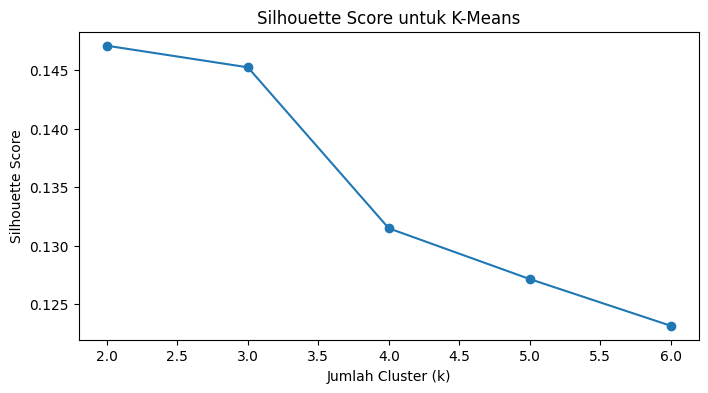

In [ ]:
# Menentukan jumlah cluster optimal (bisa dari Silhouette/Elbow, mencoba k=2..6)
range_k = range(2, 7)
silhouette_scores = []

for k in range_k:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

# Plot Silhouette Score untuk tiap k
plt.figure(figsize=(8,4))
plt.plot(range_k, silhouette_scores, marker='o')
plt.title('Silhouette Score untuk K-Means')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Silhouette Score')
plt.show()

In [ ]:
# Pilih k terbaik
best_k = range_k[np.argmax(silhouette_scores)]
print(f"Best k: {best_k} dengan Silhouette Score {max(silhouette_scores):.4f}")

# Jalankan KMeans dengan k terbaik
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init='auto')
kmeans_labels = kmeans.fit_predict(X_scaled)

Best k: 2 dengan Silhouette Score 0.1471


# DBSCAN

In [ ]:
# Mencoba beberapa parameter eps & min_samples
dbscan = DBSCAN(eps=1.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Cek jumlah cluster terbentuk
unique_labels = np.unique(dbscan_labels)
print("Label cluster DBSCAN:", unique_labels)

Label cluster DBSCAN: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


# Evaluasi Hasil Clustering

In [ ]:
# Evaluasi K-Means
silhouette_kmeans = silhouette_score(X_scaled, kmeans_labels)
davies_kmeans = davies_bouldin_score(X_scaled, kmeans_labels)

# Evaluasi DBSCAN
# Untuk DBSCAN, perlu memastikan jumlah cluster > 1
if len(np.unique(dbscan_labels)) > 1:
    silhouette_dbscan = silhouette_score(X_scaled, dbscan_labels)
    davies_dbscan = davies_bouldin_score(X_scaled, dbscan_labels)
else:
    silhouette_dbscan = np.nan
    davies_dbscan = np.nan

print(f"Silhouette K-Means: {silhouette_kmeans:.4f}")
print(f"Davies-Bouldin K-Means: {davies_kmeans:.4f}")
print(f"Silhouette DBSCAN: {silhouette_dbscan:.4f}")
print(f"Davies-Bouldin DBSCAN: {davies_dbscan:.4f}")

Silhouette K-Means: 0.1471
Davies-Bouldin K-Means: 2.3001
Silhouette DBSCAN: -0.1861
Davies-Bouldin DBSCAN: 1.3974


# Visualisasi Hasil

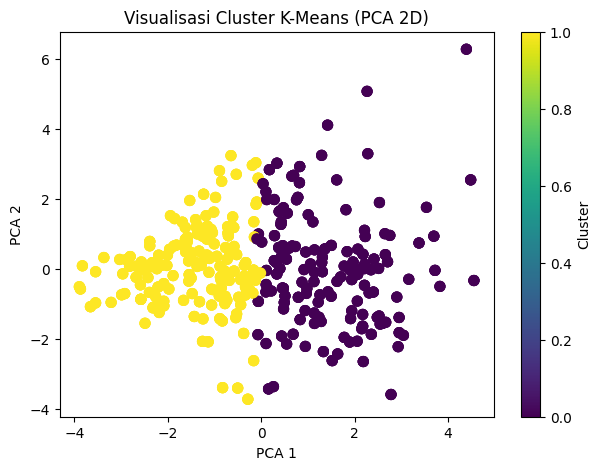

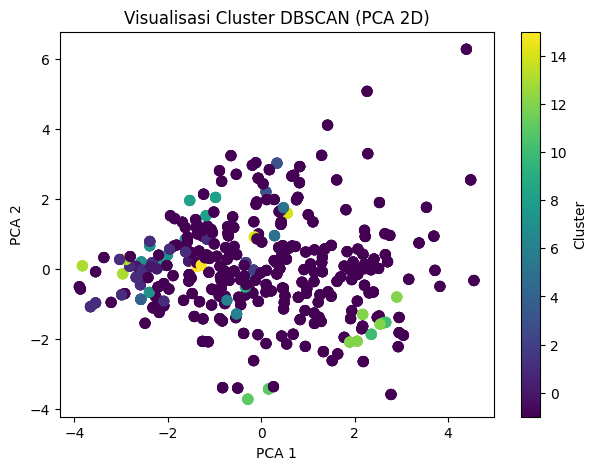

In [ ]:
# PCA untuk Reduksi Dimensi
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot K-Means
plt.figure(figsize=(7,5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', s=50)
plt.title('Visualisasi Cluster K-Means (PCA 2D)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.show()

# Plot DBSCAN
plt.figure(figsize=(7,5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='viridis', s=50)
plt.title('Visualisasi Cluster DBSCAN (PCA 2D)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.show()

# ANN - Annoy Index

In [ ]:
# Annoy Index
f = X_pca.shape[1]  # jumlah dimensi (2 dari PCA)
annoy_index = AnnoyIndex(f, 'euclidean')

# Tambahkan semua data ke index
for i in range(len(X_pca)):
    annoy_index.add_item(i, X_pca[i])

# Bangun index
annoy_index.build(10)  # 10 trees

# Pilih beberapa titik acak sebagai query
np.random.seed(42)
query_indices = np.random.choice(len(X_pca), size=3, replace=False)

for idx in query_indices:
    neighbors = annoy_index.get_nns_by_item(idx, 5, include_distances=True)
    print(f"\nQuery Index: {idx}")
    print(f"Label Cluster: {kmeans_labels[idx]}")
    print("Tetangga Terdekat (index, jarak):")
    for n, d in zip(neighbors[0], neighbors[1]):
        print(f" - {n} | jarak: {d:.4f} | cluster: {kmeans_labels[n]}")


Query Index: 527
Label Cluster: 1
Tetangga Terdekat (index, jarak):
 - 91 | jarak: 0.0000 | cluster: 1
 - 200 | jarak: 0.0000 | cluster: 1
 - 418 | jarak: 0.0000 | cluster: 1
 - 527 | jarak: 0.0000 | cluster: 1
 - 582 | jarak: 0.1272 | cluster: 1

Query Index: 359
Label Cluster: 1
Tetangga Terdekat (index, jarak):
 - 319 | jarak: 0.0000 | cluster: 1
 - 329 | jarak: 0.0000 | cluster: 1
 - 359 | jarak: 0.0000 | cluster: 1
 - 426 | jarak: 0.1658 | cluster: 1
 - 568 | jarak: 0.1658 | cluster: 1

Query Index: 447
Label Cluster: 0
Tetangga Terdekat (index, jarak):
 - 7 | jarak: 0.0000 | cluster: 0
 - 278 | jarak: 0.0000 | cluster: 0
 - 447 | jarak: 0.0000 | cluster: 0
 - 785 | jarak: 0.0000 | cluster: 0
 - 11 | jarak: 0.1982 | cluster: 0


# Kesimpulan Analisis

In [ ]:
# --- Kesimpulan ---
print("=== KESIMPULAN ===")
if silhouette_kmeans > silhouette_dbscan:
    print("K-Means menghasilkan Silhouette Score lebih tinggi → lebih baik untuk dataset ini.")
else:
    print("DBSCAN menghasilkan Silhouette Score lebih tinggi → lebih baik untuk dataset ini.")

print(f"K-Means: Silhouette={silhouette_kmeans:.4f}, DBI={davies_kmeans:.4f}")
print(f"DBSCAN: Silhouette={silhouette_dbscan:.4f}, DBI={davies_dbscan:.4f}")

print("\nFitur tambahan CholAge berhasil ditambahkan dan dapat meningkatkan variasi data.")
print("Visualisasi PCA memperlihatkan sebaran cluster yang cukup jelas.")
print("Annoy Index memudahkan pencarian tetangga terdekat pada data hasil clustering.")

=== KESIMPULAN ===
K-Means menghasilkan Silhouette Score lebih tinggi → lebih baik untuk dataset ini.
K-Means: Silhouette=0.1471, DBI=2.3001
DBSCAN: Silhouette=-0.1861, DBI=1.3974

Fitur tambahan CholAge berhasil ditambahkan dan dapat meningkatkan variasi data.
Visualisasi PCA memperlihatkan sebaran cluster yang cukup jelas.
Annoy Index memudahkan pencarian tetangga terdekat pada data hasil clustering.
